In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn
from tensorflow.keras.regularizers import l2
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner as kt

In [ ]:
# Load the dataset
url = 'parkinsons_updrs.data.csv'
data = pd.read_csv(url)

# Drop unnecessary columns
data = data.drop(columns=['subject#', 'test_time'])

# Separate features and targets
X = data.drop(columns=['motor_UPDRS', 'total_UPDRS'])
y = data[['motor_UPDRS', 'total_UPDRS']]

# Split the data into training and testing sets
X_trainVal_raw, X_test_raw, y_trainVal, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Further split the training data into training and validation sets
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_trainVal_raw, y_trainVal, test_size=0.2, random_state=42)



In [ ]:
# Scale the features
scaler = StandardScaler()
X_processed = scaler.fit_transform(X)
X_trainVal = scaler.fit_transform(X_trainVal_raw)
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
X_val = scaler.fit_transform(X_val_raw)
feature_names = X.columns

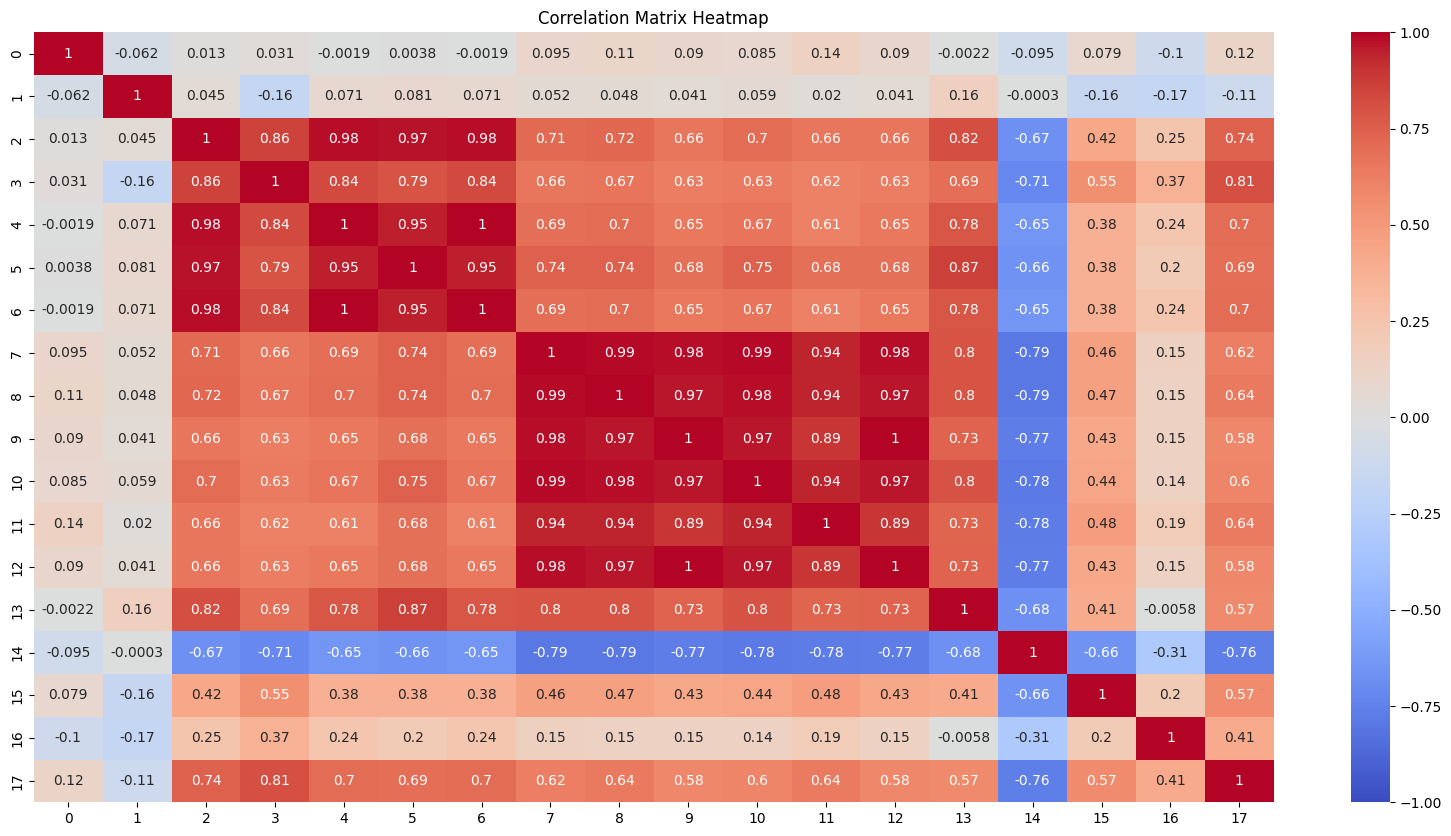

In [ ]:
corr_matrix = pd.DataFrame(X_train).corr()

plt.figure(figsize=(20, 10))  # Adjust the figure size if necessary
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

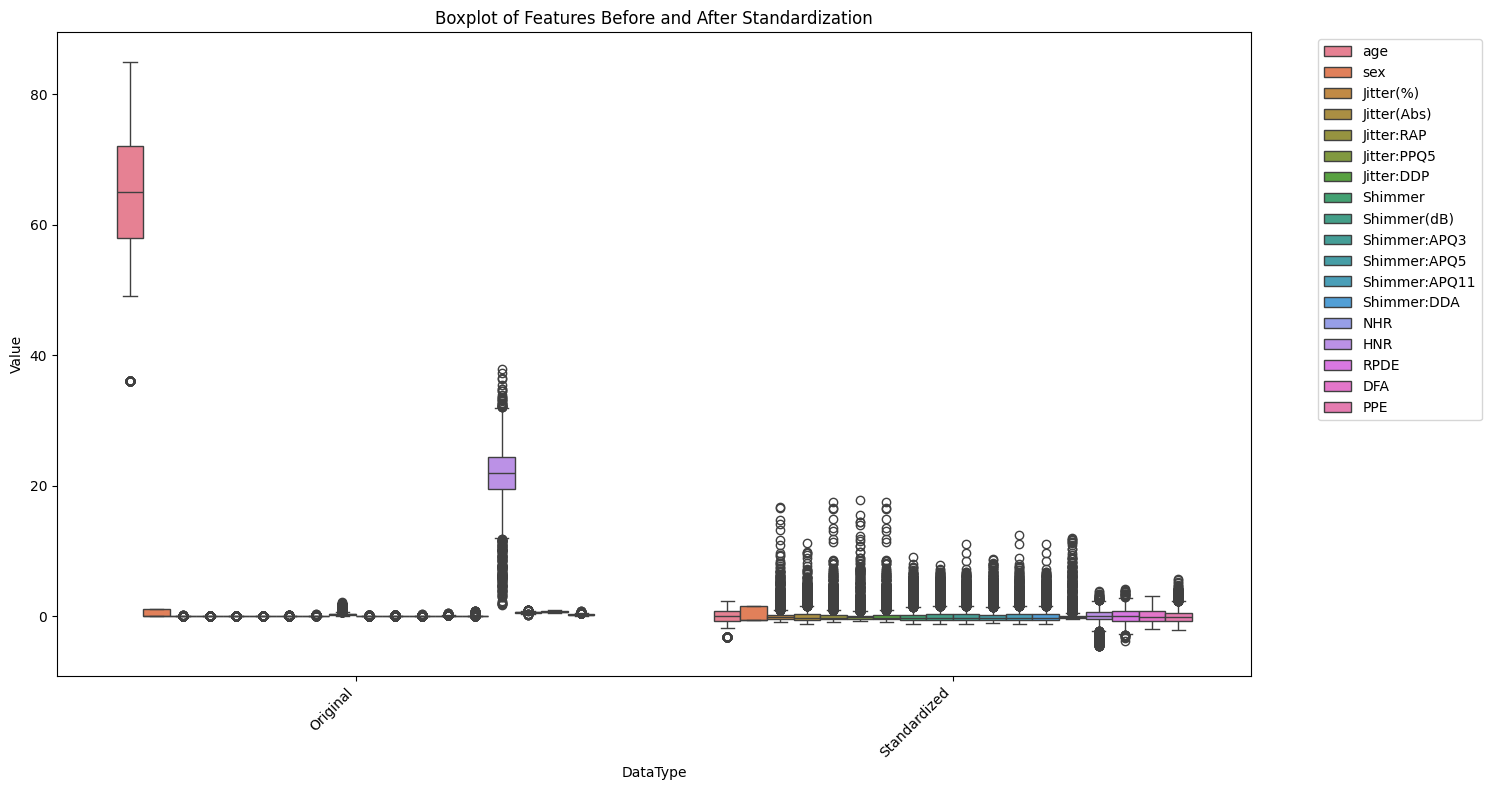

In [ ]:
def plot_boxplots(original_data, scaled_data, feature_names):
    df_original = pd.DataFrame(original_data, columns=feature_names)
    df_scaled = pd.DataFrame(scaled_data, columns=feature_names)

    df_original['DataType'] = 'Original'
    df_scaled['DataType'] = 'Standardized'

    df_combined = pd.concat([df_original, df_scaled], ignore_index=True)

    plt.figure(figsize=(15, 8))
    # Melt the DataFrame to long format for seaborn
    df_melted = df_combined.melt(id_vars='DataType', var_name='Feature', value_name='Value')
    sns.boxplot(data=df_melted, x='DataType', y='Value', hue='Feature') # Use 'Value' for y-axis
    plt.title('Boxplot of Features Before and After Standardization')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

# Assuming feature_names is a list of your feature names
plot_boxplots(X, X_processed, feature_names)

# **Neural Network Model Training**

In [ ]:
import os
import shutil
import keras_tuner
from keras.models import Sequential
from keras.layers import Dense, Input
from keras_tuner import Hyperband, BayesianOptimization
from keras.regularizers import l2
import tensorflow as tf

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(18,)))
    model.add(Dense(
        hp.Choice('units_layer1', [64]),  # Number of units for layer 1
        activation='relu',  # Corrected syntax
        kernel_regularizer=l2(hp.Choice('reg_layer1', [0.0001, 0.001]))  # Regularization for layer 1
    ))
    model.add(Dense(
        hp.Choice('units_layer2', [64]),  # Number of units for layer 2
        activation='relu',  # Corrected syntax
        kernel_regularizer=l2(hp.Choice('reg_layer2', [0.0001, 0.001]))  # Regularization for layer 2
    ))
    model.add(Dense(
        hp.Choice('units_layer3', [32]),  # Number of units for layer 3
        activation='relu',
        kernel_regularizer=l2(hp.Choice('reg_layer3', [0.0001, 0.001, 0.01]))  # Regularization for layer 3
    ))
    model.add(Dense(
        hp.Choice('units_layer4', [32]),  # Number of units for layer 4
        activation='relu',
        kernel_regularizer=l2(hp.Choice('reg_layer4', [0.0001, 0.001, 0.01]))  # Regularization for layer 4
    ))
    model.add(Dense(2, activation='relu'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.01, 0.1])),
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model

# Clear the directory before running the tuner
directory = 'my_dir'
if os.path.exists(directory):
    shutil.rmtree(directory)

# Example with BayesianOptimization
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,  # Adjust based on your resource constraints
    directory='my_dir',
    project_name='model_tuning'
)

# Start the search
tuner.search(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_val, y_val))

# Get the best model
best_model_NN = tuner.get_best_models()[0]

# To get a summary of the best model
best_model_NN.summary()


Trial 10 Complete [00h 01m 05s]
val_loss: 88.69933319091797

Best val_loss So Far: 16.91322898864746
Total elapsed time: 00h 11m 16s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,578 (33.51 KB)

 Trainable params: 8,578 (33.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the best model found by the tuner on the full dataset
history_best_model = best_model_NN.fit(X_train, y_train, epochs=200, batch_size=8, validation_split=0.2, verbose=1)

Epoch 1/200
376/376 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 16.0831 - val_accuracy: 1.0000 - val_loss: 11.5733
Epoch 2/200
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 13.1912 - val_accuracy: 1.0000 - val_loss: 14.4500
Epoch 3/200
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 16.3364 - val_accuracy: 0.9987 - val_loss: 12.6648
Epoch 4/200
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 14.9169 - val_accuracy: 1.0000 - val_loss: 16.3486
Epoch 5/200
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 14.8875 - val_accuracy: 1.0000 - val_loss: 14.1613
Epoch 6/200
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 13.6451 - val_accuracy: 1.0000 - val_loss: 14.4623
Epoch 7/200
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 12.9042 - val_accuracy: 1.0000 - val_loss: 15.2884
Epoch 8/200
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 12.

# **Random Forest Model Training**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define the parameter grid
param_distributions = {
    'n_estimators': [400],  # Range of number of trees
    'criterion': ['squared_error'],  # Different criteria for split quality
    'max_depth': [None],  # Varying depth of trees
    'min_samples_split': [2],  # Number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Number of samples required to be at a leaf node
    'min_weight_fraction_leaf': [0.0],  # Minimum weighted fraction of the sum total of weights
    'max_features': [None],  # Number of features to consider when looking for the best split
    'max_leaf_nodes': [None],  # Maximum number of leaf nodes
    'min_impurity_decrease': [0.0],  # Minimum impurity decrease required to split a node
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'oob_score': [True, False],  # Whether to use out-of-bag samples to estimate the generalization accuracy
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor()

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_trainVal, y_trainVal)

# Get the best model
best_model_RF = random_search.best_estimator_

# Print the best parameters
print(f"Best Parameters: {random_search.best_params_}")

# To view a summary of the model, we can print its details
print(best_model_RF)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent c

Best Parameters: {'oob_score': True, 'n_estimators': 400, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': None, 'criterion': 'squared_error', 'bootstrap': True}
RandomForestRegressor(max_features=None, n_estimators=400, oob_score=True)


In [ ]:

y_val_pred = best_model_RF.predict(X_test)

# Compute Mean Squared Error (validation loss)
val_loss = mean_squared_error(y_test, y_val_pred)
print(f"Validation Loss (MSE): {val_loss:.4f}")

# Compute R-squared score
r2 = r2_score(y_test, y_val_pred)
print(f"R-squared Score: {r2:.4f}")

Validation Loss (MSE): 6.9748
R-squared Score: 0.9187


# **Predicting values from NN and RF**

In [ ]:

# Randomly select an index from the test set
random_index = np.random.randint(0, len(X_test))

# Select the data point and its actual value
single_data_point = X_test[random_index].reshape(1, -1)
actual_value = y_test.iloc[random_index]

# Use the trained model to make a prediction
predicted_value_NN = best_model_NN.predict(single_data_point)
predicted_value_RF = best_model_RF.predict(single_data_point)
y_val_pred_combined = (predicted_value_NN + predicted_value_RF) / 2

# Display the results
print("Actual value (motor_UPDRS, total_UPDRS):", actual_value.values)
print("Predicted_NN value (motor_UPDRS, total_UPDRS):", predicted_value_NN[0])
print("Predicted_RF value (motor_UPDRS, total_UPDRS):", predicted_value_RF[0])
print("Predicted_Average value (motor_UPDRS, total_UPDRS):",y_val_pred_combined[0] )


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Actual value (motor_UPDRS, total_UPDRS): [12.208 14.604]
Predicted_NN value (motor_UPDRS, total_UPDRS): [14.267052 18.054455]
Predicted_RF value (motor_UPDRS, total_UPDRS): [12.9678795 17.9768675]
Predicted_Average value (motor_UPDRS, total_UPDRS): [13.6174656  18.01566115]


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


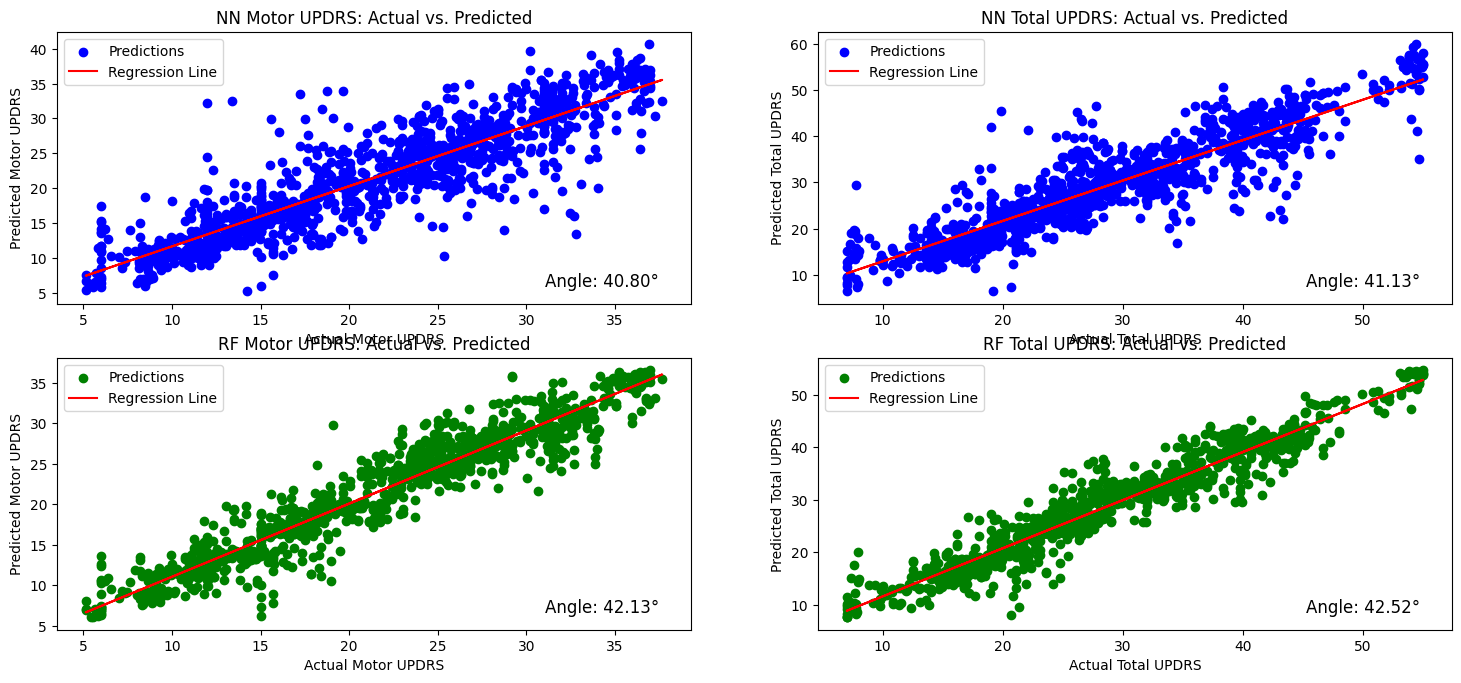

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Predict on the test data
y_pred_NN = best_model_NN.predict(X_test)
y_pred_RF = best_model_RF.predict(X_test)

# Create a scatter plot for each target variable
plt.figure(figsize=(18, 12))

def plot_with_angle(ax, actual, predicted, label, color, model_name):
    # Scatter plot
    ax.scatter(actual, predicted, label='Predictions', color=color)

    # Calculate the regression line
    slope, intercept = np.polyfit(actual, predicted, 1)
    regression_line = slope * actual + intercept
    ax.plot(actual, regression_line, color='red', label='Regression Line')

    # Calculate and print the angle
    angle = np.degrees(np.arctan(slope))
    ax.text(0.95, 0.05, f'Angle: {angle:.2f}°', transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

    # Set labels and title
    ax.set_xlabel(f'Actual {label}')
    ax.set_ylabel(f'Predicted {label}')
    ax.set_title(f'{model_name} {label}: Actual vs. Predicted')
    ax.legend()

# For Motor UPDRS
plt.subplot(3, 2, 1)
plot_with_angle(plt.gca(), y_test['motor_UPDRS'], y_pred_NN[:, 0], 'Motor UPDRS', 'blue', 'NN')

plt.subplot(3, 2, 2)
plot_with_angle(plt.gca(), y_test['total_UPDRS'], y_pred_NN[:, 1], 'Total UPDRS', 'blue', 'NN')

# For Random Forest
plt.subplot(3, 2, 3)
plot_with_angle(plt.gca(), y_test['motor_UPDRS'], y_pred_RF[:, 0], 'Motor UPDRS', 'green', 'RF')

plt.subplot(3, 2, 4)
plot_with_angle(plt.gca(), y_test['total_UPDRS'], y_pred_RF[:, 1], 'Total UPDRS', 'green', 'RF')


# **Generating new dataset of predictions combined (2*RF+NN)/3 and the difference between actual and combined**

In [ ]:
# Get predictions for the entire test set
predictions_NN = best_model_NN.predict(X_test)
predictions_RF = best_model_RF.predict(X_test)

# Extract the columns for motor_UPDRS and total_UPDRS
predictions_NN_motor = predictions_NN[:, 0]
predictions_NN_total = predictions_NN[:, 1]
predictions_RF_motor = predictions_RF[:, 0]
predictions_RF_total = predictions_RF[:, 1]
predictions_combined_motor = (predictions_NN_motor + (2 * predictions_RF_motor)) / 3
predictions_combined_total = (predictions_NN_total + (2 * predictions_RF_total)) / 3

# Extract actual values for motor_UPDRS and total_UPDRS
actual_motor = y_test.values[:, 0]
actual_total = y_test.values[:, 1]

# Create DataFrame
results_df = pd.DataFrame({
    'predicted_combined_motor': predictions_combined_motor,
    'predicted_combined_total': predictions_combined_total,
    'actual_motor_diff': actual_motor - predictions_combined_motor,
    'actual_total_diff': actual_total - predictions_combined_total,
})

# Check the DataFrame
print(results_df.head())

# Save the dataset to a CSV file if needed
results_df.to_csv('predictions_dataset.csv', index=False)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
   predicted_combined_motor  predicted_combined_total  actual_motor_diff  \
0                 27.322502                 36.246867           5.761498   
1                  9.065426                 12.492859          -1.905526   
2                 12.608076                 15.411728          -1.390076   
3                 14.583505                 19.119241          -1.824505   
4                 22.995169                 29.836300           2.395831   

   actual_total_diff  
0           7.316133  
1          -0.432859  
2          -1.302728  
3          -2.602241  
4           2.163700  


In [ ]:
# Load the dataset
url = 'predictions_dataset.csv'
data_pred = pd.read_csv(url)

# Separate features and targets
X_train_pred = data_pred[['predicted_combined_motor','predicted_combined_total']] # Use square brackets to select columns
y_train_act = data_pred[['actual_motor_diff', 'actual_total_diff']]

**RF based training**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_RF_avg = RandomForestRegressor()
model_RF_avg.fit(X_train_pred, y_train_act)

RandomForestRegressor()

**Plotting**

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


<Figure size 1800x1200 with 0 Axes>

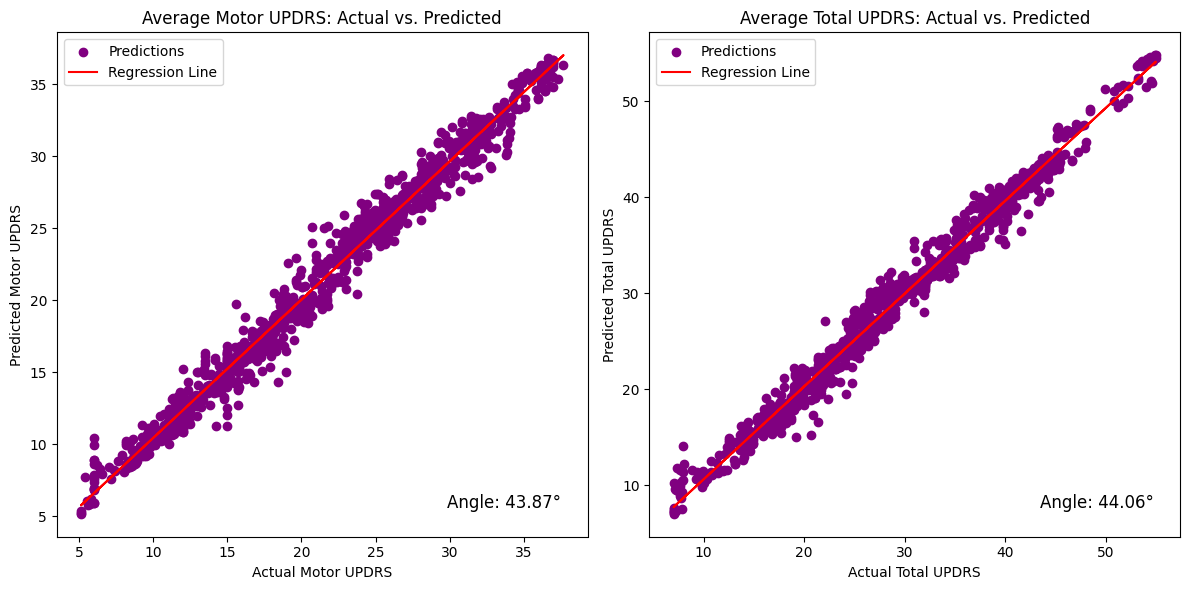

In [ ]:
# Make a prediction using the new model
y_val_pred_NN = best_model_NN.predict(X_test)
y_val_pred_RF = best_model_RF.predict(X_test)
y_val_pred_combined = (y_val_pred_NN + (2 * y_val_pred_RF)) / 3
y_val_pred_diff = model_RF_avg.predict(y_val_pred_combined)
y_val_pred = y_val_pred_combined + y_val_pred_diff

# Create a scatter plot for each target variable
plt.figure(figsize=(18, 12))

def plot_with_angle(ax, actual, predicted, label, color, model_name):
    # Scatter plot
    ax.scatter(actual, predicted, label='Predictions', color=color)

    # Calculate the regression line
    slope, intercept = np.polyfit(actual, predicted, 1)
    regression_line = slope * actual + intercept
    ax.plot(actual, regression_line, color='red', label='Regression Line')

    # Calculate and print the angle
    angle = np.degrees(np.arctan(slope))
    ax.text(0.95, 0.05, f'Angle: {angle:.2f}°', transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

    # Set labels and title
    ax.set_xlabel(f'Actual {label}')
    ax.set_ylabel(f'Predicted {label}')
    ax.set_title(f'{model_name} {label}: Actual vs. Predicted')
    ax.legend()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_with_angle(plt.gca(), y_test['motor_UPDRS'], y_val_pred[:, 0], 'Motor UPDRS', 'purple', 'Average')

plt.subplot(1, 2, 2)
plot_with_angle(plt.gca(), y_test['total_UPDRS'], y_val_pred[:, 1], 'Total UPDRS', 'purple', 'Average')

plt.tight_layout()
plt.show()


# **Getting the Final MSE for the Hybrid Ensemble vs NN vs RF**

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Use the trained models to make predictions
predicted_value_NN = best_model_NN.predict(X_test)
predicted_value_RF = best_model_RF.predict(X_test)

# Combined prediction
y_val_pred_combined = (predicted_value_NN + (2 * predicted_value_RF)) / 3

# Predictions from individual models
y_test_pred_RF = best_model_RF.predict(X_test)
y_test_pred_NN = best_model_NN.predict(X_test)

# Compute and print Mean Squared Error (MSE) for RF model
val_loss_RF = mean_squared_error(y_test, y_test_pred_RF)
print(f"Validation Loss RF (MSE): {val_loss_RF:.4f}")

# Compute and print R-squared for RF model
r2_RF = r2_score(y_test, y_test_pred_RF)
print(f"R-squared RF: {r2_RF:.4f}")

# Compute and print Mean Squared Error (MSE) for NN model
val_loss_NN = mean_squared_error(y_test, y_test_pred_NN)
print(f"Validation Loss NN (MSE): {val_loss_NN:.4f}")

# Compute and print R-squared for NN model
r2_NN = r2_score(y_test, y_test_pred_NN)
print(f"R-squared NN: {r2_NN:.4f}")

# Predict the difference with the RF average model and adjust combined prediction
y_test_pred_diff = model_RF_avg.predict(y_val_pred_combined)
y_test_pred_hybrid = y_val_pred_combined + y_test_pred_diff

# Compute and print Mean Squared Error (MSE) for hybrid ensemble model
val_loss_hybrid = mean_squared_error(y_test, y_test_pred_hybrid)
print(f"Validation Loss Model Hybrid Ensemble (MSE): {val_loss_hybrid:.4f}")

# Compute and print R-squared for hybrid ensemble model
r2_hybrid = r2_score(y_test, y_test_pred_hybrid)
print(f"R-squared Model Hybrid Ensemble: {r2_hybrid:.4f}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Validation Loss RF (MSE): 6.9748
R-squared RF: 0.9187
Validation Loss NN (MSE): 18.9306
R-squared NN: 0.7802
Validation Loss Model Hybrid Ensemble (MSE): 1.4160
R-squared Model Hybrid Ensemble: 0.9834


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
random_index = np.random.randint(0, len(X_test))

# Select the data point and its actual value
single_data_point_pred = X_test[random_index].reshape(1, -1)
actual_value_pred = y_test.iloc[random_index]

# Make a prediction using the new model
y_val_pred_NN = best_model_NN.predict(single_data_point_pred)
y_val_pred_RF = best_model_RF.predict(single_data_point_pred)
y_val_pred_combined = (y_val_pred_NN + (2 *y_val_pred_RF)) / 3
y_val_pred_diff = model_RF_avg.predict(y_val_pred_combined.reshape(1,-1))
y_val_pred = y_val_pred_combined + y_val_pred_diff

# Display the results
print("Actual value (motor_UPDRS, total_UPDRS):", actual_value_pred.values)
print("Predicted_Average value (motor_UPDRS, total_UPDRS):", y_val_pred[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Actual value (motor_UPDRS, total_UPDRS): [17.    24.073]
Predicted_Average value (motor_UPDRS, total_UPDRS): [17.07019175 24.16438979]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
